In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
BASE_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15/test")
SATELLITE_PATH = BASE_PATH / "satellite"
OPT_FLOW_PATH = BASE_PATH / "opticalflow"
BATCH_FILENAME = "000170.nc"

assert SATELLITE_PATH.exists()
assert OPT_FLOW_PATH.exists()

In [4]:
satellite_filename = SATELLITE_PATH / BATCH_FILENAME
opt_flow_filename = OPT_FLOW_PATH / BATCH_FILENAME

assert satellite_filename.exists()
assert opt_flow_filename.exists()

In [5]:
sat_batch = xr.load_dataset(satellite_filename, mode="r")

In [6]:
opt_flow_batch = xr.load_dataset(opt_flow_filename, mode="r")

In [7]:
sat_batch

<xarray.Dataset>
Dimensions:         (example: 32, channels_index: 11, time_index: 31, x_index: 24, y_index: 24)
Coordinates:
  * channels_index  (channels_index) int64 0 1 2 3 4 5 6 7 8 9 10
  * example         (example) int64 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
  * time_index      (time_index) int64 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30
  * x_index         (x_index) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * y_index         (y_index) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    channels        (example, channels_index) object 'IR_016' ... 'WV_073'
    data            (example, time_index, x_index, y_index, channels_index) int16 ...
    time            (example, time_index) datetime64[ns] 2021-03-22T13:20:00 ...
    x               (example, x_index) float64 3.368e+05 3.401e+05 ... 5.419e+05
    y               (example, y_index) float64 6.92e+05 6.992e+05 ... 2.449e+05

In [8]:
sat_batch["data"].encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15/test/satellite/000170.nc',
 'original_shape': (32, 31, 24, 24, 11),
 'dtype': dtype('int16')}

In [9]:
opt_flow_batch

<xarray.Dataset>
Dimensions:         (example: 32, channels_index: 11, time_index: 24, x_index: 24, y_index: 24)
Coordinates:
  * channels_index  (channels_index) int64 0 1 2 3 4 5 6 7 8 9 10
  * example         (example) int64 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
  * time_index      (time_index) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
  * x_index         (x_index) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * y_index         (y_index) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    channels        (example, channels_index) object 'IR_016' ... 'WV_073'
    data            (example, time_index, x_index, y_index, channels_index) int16 ...
    time            (example, time_index) datetime64[ns] 2021-03-22T13:55:00 ...
    x               (example, x_index) float64 3.368e+05 3.401e+05 ... 5.419e+05
    y               (example, y_index) float64 6.92e+05 6.992e+05 ... 2.449e+05

In [10]:
opt_flow_batch["data"].encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (8, 6, 6, 12, 6),
 'source': '/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15/test/opticalflow/000170.nc',
 'original_shape': (32, 24, 24, 24, 11),
 'dtype': dtype('int16')}

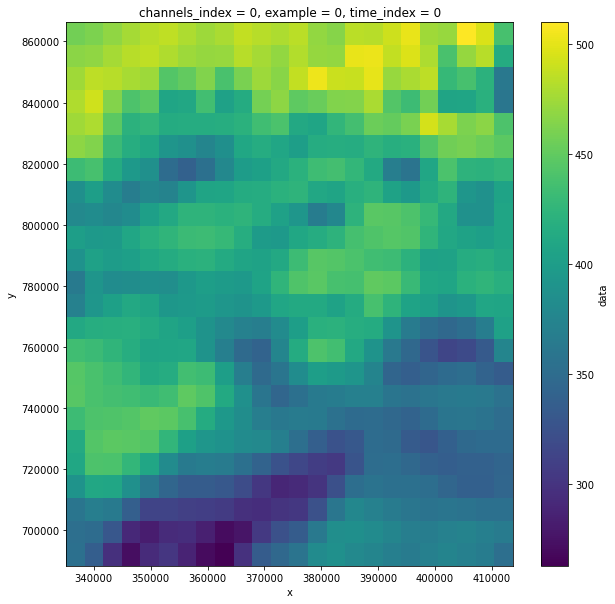

In [13]:
EXAMPLE_I = 0

opt_flow_batch["data"].sel(example=EXAMPLE_I, channels_index=0, time_index=0).assign_coords(
    x=(
        "x_index", 
        opt_flow_batch["x"].sel(example=EXAMPLE_I).data
    ),
    y=(
        "y_index", 
        opt_flow_batch["y"].sel(example=EXAMPLE_I).data
    )
).swap_dims(
    {
        "x_index": "x",
        "y_index": "y"
    }
).plot.imshow(x="x", y="y", figsize=(10, 10))

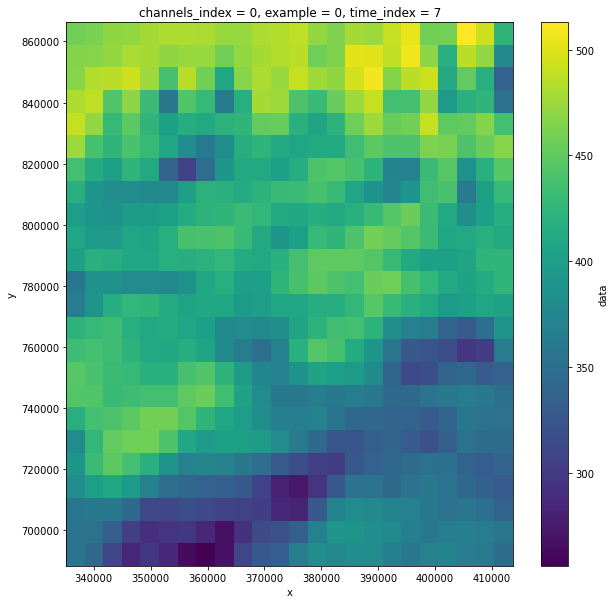

In [14]:
sat_batch["data"].sel(example=EXAMPLE_I, channels_index=0, time_index=7).assign_coords(
    x=(
        "x_index", 
        sat_batch["x"].sel(example=EXAMPLE_I).data
    ),
    y=(
        "y_index", 
        sat_batch["y"].sel(example=EXAMPLE_I).data
    )
).swap_dims(
    {
        "x_index": "x",
        "y_index": "y"
    }
).plot.imshow(x="x", y="y", figsize=(10, 10))

In [15]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from nowcasting_dataset.data_sources.optical_flow.optical_flow_data_source import crop_center

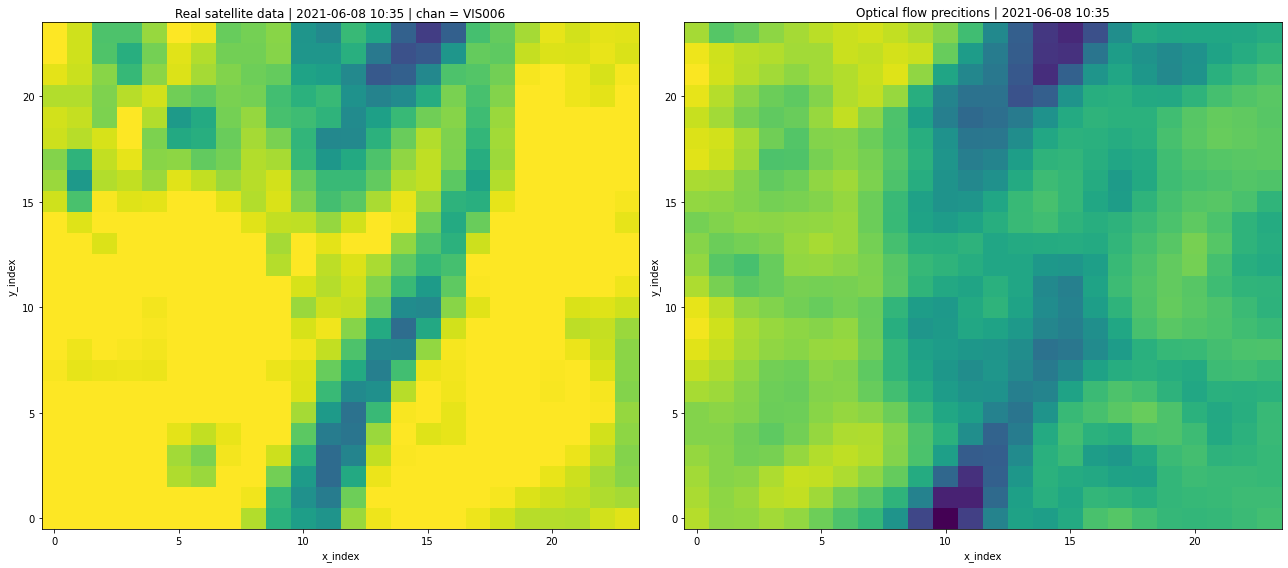

In [32]:
EXAMPLE_I = 6
CHANNEL_I = 7
HISTORY_LENGTH = 7
sat_data = sat_batch["data"].sel(example=EXAMPLE_I, channels_index=CHANNEL_I)
channel_name = sat_batch["channels"].sel(example=EXAMPLE_I, channels_index=CHANNEL_I).values
opt_flow_data = opt_flow_batch["data"].sel(example=EXAMPLE_I, channels_index=CHANNEL_I)
min_pixel_val = min(sat_data.min(), opt_flow_data.min())
max_pixel_val = min(sat_data.max(), opt_flow_data.max())
imshow_kwargs = dict(x='x_index', y='y_index', add_colorbar=False, vmin=min_pixel_val, vmax=max_pixel_val)

fig, axes = plt.subplots(figsize=(18, 8), ncols=2)

ax = axes[0]
sat_img = sat_data.isel(time_index=0).plot.imshow(ax=ax, **imshow_kwargs)

ax = axes[1]
opt_flow_img = opt_flow_data.isel(time_index=0).plot.imshow(ax=ax, **imshow_kwargs)
OPT_FLOW_TITLE = "Optical flow precitions"
ax.set_title(OPT_FLOW_TITLE)


def format_date(dt: np.datetime64) -> str:
    return pd.Timestamp(dt).strftime("%Y-%m-%d %H:%M")

plt.tight_layout()

def init():
    sat_img.set_data(sat_data.isel(time_index=0))
    axes[1].set_title(OPT_FLOW_TITLE)
    opt_flow_img.set_data(np.full(shape=opt_flow_data.isel(time_index=0).shape, fill_value=np.NaN))
    return sat_img, opt_flow_img

def update(i):
    # SAT DATA
    sat_img.set_data(sat_data.isel(time_index=i))
    datetime = sat_batch["time"].isel(example=EXAMPLE_I, time_index=i).values
    axes[0].set_title("Real satellite data | " + format_date(datetime) + " | chan = " + channel_name)
    
    # OPTICAL FLOW PREDICTIONS
    if i > HISTORY_LENGTH:
        opt_flow_datetime = opt_flow_batch["time"].isel(example=EXAMPLE_I, time_index=i-HISTORY_LENGTH).values
        axes[1].set_title(OPT_FLOW_TITLE + " | " + format_date(opt_flow_datetime))
        new_opt_flow_data = opt_flow_data.isel(time_index=i-HISTORY_LENGTH).values.copy()
        opt_flow_img.set_data(new_opt_flow_data)
    return sat_img, opt_flow_img

anim = FuncAnimation(fig, func=update, frames=np.arange(30), init_func=init, interval=250, blit=True)
#anim.save('optical_flow.gif', writer='imagemagick')
html = anim.to_html5_video()
HTML(html)

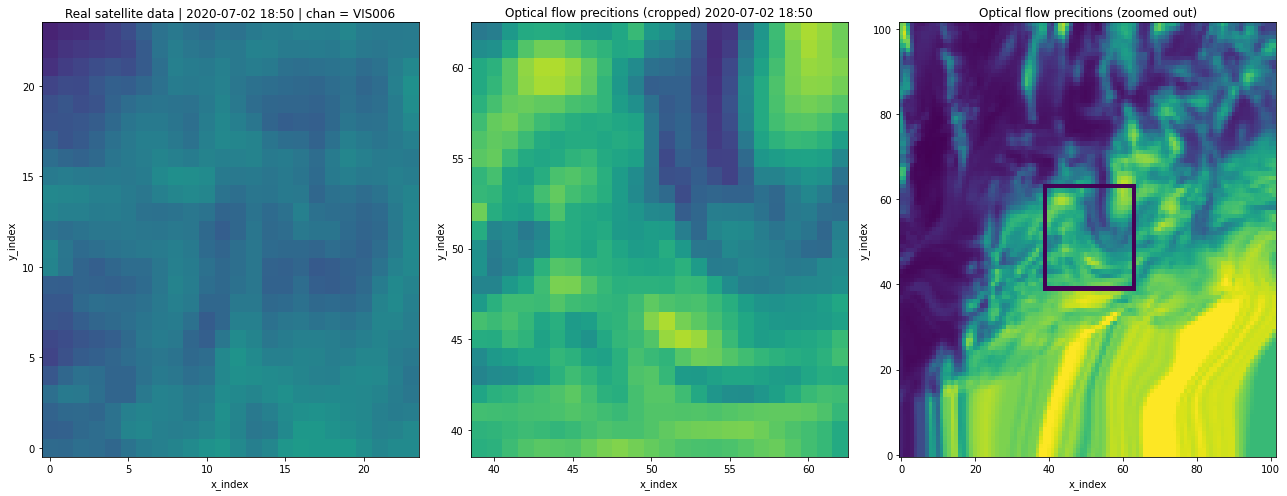

In [126]:
EXAMPLE_I = 2
CHANNEL_I = 7
HISTORY_LENGTH = 6
sat_data = sat_batch["data"].sel(example=EXAMPLE_I, channels_index=CHANNEL_I)
channel_name = sat_batch["channels"].sel(example=EXAMPLE_I, channels_index=CHANNEL_I).values
opt_flow_data = opt_flow_batch["data"].sel(example=EXAMPLE_I, channels_index=CHANNEL_I)
min_pixel_val = min(sat_data.min(), opt_flow_data.min())
max_pixel_val = min(sat_data.max(), opt_flow_data.max())
imshow_kwargs = dict(x='x_index', y='y_index', add_colorbar=False, vmin=min_pixel_val, vmax=max_pixel_val)

fig, axes = plt.subplots(figsize=(18, 7), ncols=3)

ax = axes[0]
sat_img = sat_data.isel(time_index=0).plot.imshow(ax=ax, **imshow_kwargs)

ax = axes[1]
opt_flow_cropped_img = crop_center(
    opt_flow_data.isel(time_index=0),
    24,
    24
).plot.imshow(ax=ax, **imshow_kwargs)
OPT_FLOW_TITLE = "Optical flow precitions (cropped) "
ax.set_title(OPT_FLOW_TITLE)

ax = axes[2]
opt_flow_img = opt_flow_data.isel(time_index=0).plot.imshow(ax=ax, **imshow_kwargs)
ax.set_title("Optical flow precitions (zoomed out)")


def format_date(dt: np.datetime64) -> str:
    return pd.Timestamp(dt).strftime("%Y-%m-%d %H:%M")

plt.tight_layout()

def init():
    sat_img.set_data(sat_data.isel(time_index=0))
    axes[1].set_title(OPT_FLOW_TITLE)
    opt_flow_cropped_img.set_data(np.full(shape=sat_data.isel(time_index=0).shape, fill_value=np.NaN))
    opt_flow_img.set_data(np.full(shape=opt_flow_data.isel(time_index=0).shape, fill_value=np.NaN))
    return sat_img, opt_flow_cropped_img, opt_flow_img

def update(i):
    # SAT DATA
    sat_img.set_data(sat_data.isel(time_index=i))
    datetime = sat_batch["time"].isel(example=EXAMPLE_I, time_index=i).values
    axes[0].set_title("Real satellite data | " + format_date(datetime) + " | chan = " + channel_name)
    
    # OPTICAL FLOW PREDICTIONS
    if i > HISTORY_LENGTH:
        opt_flow_datetime = opt_flow_batch["time"].isel(example=EXAMPLE_I, time_index=i-HISTORY_LENGTH).values
        axes[1].set_title(OPT_FLOW_TITLE + format_date(opt_flow_datetime))
        new_opt_flow_data = opt_flow_data.isel(time_index=i-HISTORY_LENGTH).values.copy()
        opt_flow_cropped_img.set_data(
            crop_center(
                new_opt_flow_data,
                24,
                24
            )
        )
        new_opt_flow_data[[39, 63], 39:63] = 0
        new_opt_flow_data[39:64, [39, 63]] = 0
        opt_flow_img.set_data(new_opt_flow_data)
    return sat_img, opt_flow_cropped_img, opt_flow_img

anim = FuncAnimation(fig, func=update, frames=np.arange(30), init_func=init, interval=250, blit=True)
#anim.save('optical_flow.gif', writer='imagemagick')
html = anim.to_html5_video()
HTML(html)